In [1]:
import numpy as np
import pandas as pd
import pytensor.tensor as pt
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import gurobipy as grb

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# I pulled in the Native Data, but I had to take 14 weeks from Native
# because they needed to match length
media = pd.read_csv('C:/Users/norri/Desktop/native.csv', parse_dates=['DATE'])

In [3]:
# this resampling allows for the time series data to be used as daily, weekly
# quarterly, and year over year, but it has an issue where it makes
# the date the index and the program often can't find the date
media = media.resample('W-Mon', label='left', closed='left', on='DATE').sum()
media.rename(columns={'revenue': 'REVENUE'})

,display_s,brands_branded_s,brands_competitive_s,products_branded_s,products_category_s,products_competitive_s,products_auto_s,REVENUE
DATE,,,,,,,,
2021-05-31,193.95,3035.25,522.75,14792.70,222.05,102374.29,3501.05,356198.75
2021-06-07,212.27,3017.85,510.69,15085.45,143.70,97312.96,3826.08,326234.10
2021-06-14,2877.04,5775.42,568.23,23607.42,141.61,95104.56,13023.68,464649.74
2021-06-21,1531.20,4785.65,901.11,18649.37,152.92,68246.39,4170.31,314417.05
2021-06-28,1574.84,4414.59,725.89,23804.98,83.94,90652.95,4230.69,302639.04
...,...,...,...,...,...,...,...,...
2023-04-24,2902.62,5201.63,9371.46,20636.82,917.38,86395.01,3068.28,645601.54
2023-05-01,2837.77,5500.94,11472.63,21042.52,1436.33,86428.30,2937.81,643701.12
2023-05-08,2098.13,5563.91,12548.27,16422.15,1440.04,91427.54,2655.22,613608.99


In [4]:
# the author of the article took these lag and carryover
# values from industry friends, but running Arima or Sarimax
# should give us a better idea of the lag and Robyn
# a better idea of the carryover
lag = {
    "brands_branded_s": 2,
    "brands_competitive_s": 2,
    "display_s": 2,
    "products_auto_s": 2,
    "products_branded_s": 2,
    "products_category_s": 1,
    "products_competitive_s": 3
}
# why these values for retention?
retention_rate = 0.8
retention_length = 13

media_transformed = media.copy()

In [5]:
# this function changes the columns to appear more similar to each other
# and from previous experience, I'm not sure weighting most channel inputs
# is wise
for i,j in lag.items():
    weights = retention_rate ** (np.flip(np.arange(retention_length + 1) - j)**2)
    weighted_sum = lambda x: np.sum(weights[-x.shape[0]:]*x)
    media_transformed[i] = media[i].rolling(window=retention_length, closed='both', min_periods=1).apply(weighted_sum, raw=False)

In [6]:
# this is the same function in Robyn used for saturation
# though Robyn uses the weibull distributions instead of geometric
def hill_transform(x, alpha, gamma):
    return 1 / (1 + (x/gamma)**-alpha)

In [7]:
# define bias, fourier, holiday, and min-max scaling
bias = pd.DataFrame({
    "t": np.arange(104)
})

In [8]:
# I believe he picks the 4th of July, Thanksgiving, and the holidays for his holiday "bias"
bias['holiday_period'] = np.select([bias.t==26, bias.t==78, np.logical_and(bias.t>=40,bias.t<=52), np.logical_and(bias.t>=92,bias.t<=104)],[1,1,1,1],0)

In [9]:
# Min-max scaling
bias.iloc[:,1:] = (bias.iloc[:,1:] - bias.iloc[:,1:].min()) / (bias.iloc[:,1:].max() - bias.iloc[:,1:].min())

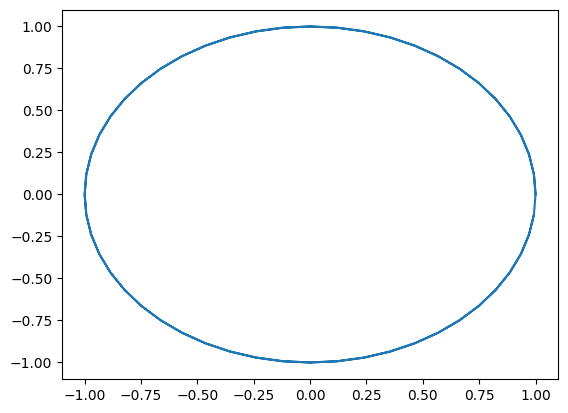

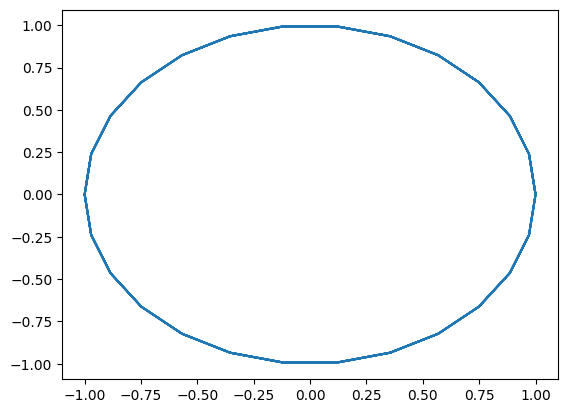

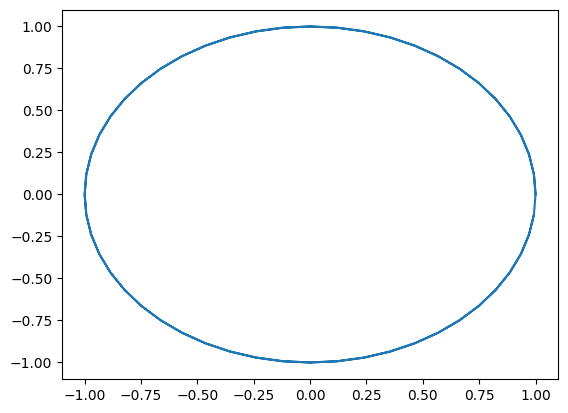

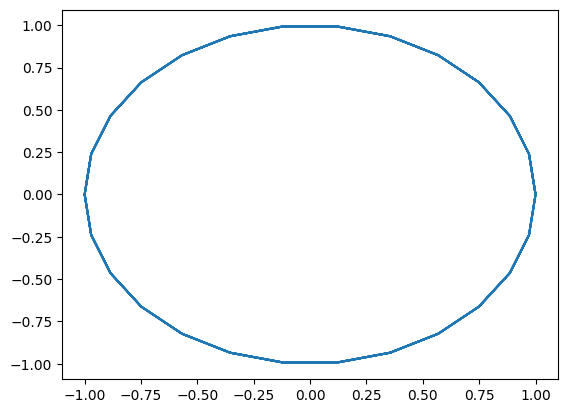

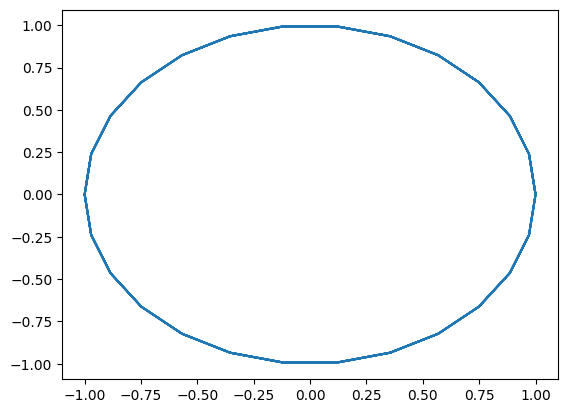

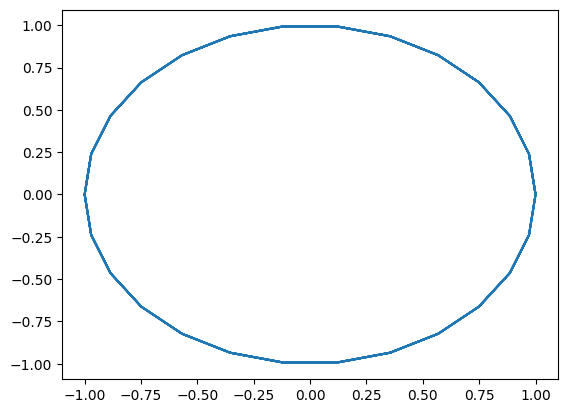

In [10]:
d = 2
# Fourier terms
for i in np.arange(1,d+1):
    bias[f"cos_{i}"] = np.cos(2 * np.pi * i * bias["t"] / 52)
    bias[f"sin_{i}"] = np.sin(2 * np.pi * i * bias["t"] / 52)

    for i in np.arange(1,d+1):
        x = np.cos(2 * np.pi * i * bias["t"] / 52)
        y = np.sin(2 * np.pi * i * bias["t"] / 52)
        plt.plot(x, y)
        plt.show()

bias.iloc[:,1:] = (bias.iloc[:,1:] - bias.iloc[:,1:].min()) / (bias.iloc[:,1:].max() - bias.iloc[:,1:].min())

e = 2
for i in np.arange(1,e+1):
    m = np.cos(2 * np.pi * i * bias["t"] / 52)
    m = np.sin(2 * np.pi * i * bias["t"] / 52)
    plt.plot(x, y)
    plt.show()

In [11]:
channel_priors = {
    "brands_branded_s": 0.02,
    "brands_competitive_s": 0.05,
    "display_s": 0.02,
    "products_auto_s": 0.03,
    "products_branded_s": 0.08,
    "products_category_s": 0.14,
    "products_competitive_s": 0.01
}

for channel in channel_priors.keys():
    # define coefficient
    channel_prior = channel_priors[channel]

trend_prior = 0.05
holiday_prior = 0.05
seasonality_prior = 0.05 / (2*d)

In [12]:
print(media.index) # the dates are still in the index

DatetimeIndex(['2021-05-31', '2021-06-07', '2021-06-14', '2021-06-21',
               '2021-06-28', '2021-07-05', '2021-07-12', '2021-07-19',
               '2021-07-26', '2021-08-02',
               ...
               '2023-03-20', '2023-03-27', '2023-04-03', '2023-04-10',
               '2023-04-17', '2023-04-24', '2023-05-01', '2023-05-08',
               '2023-05-15', '2023-05-22'],
              dtype='datetime64[ns]', name='DATE', length=104, freq=None)


In [13]:
def bayesian_mmm(splits="W"):

    if splits == "Q":
        time_series = pd.PeriodIndex('DATE', freq='Q').astype(str).str[-1].astype(int).values
    elif splits == "H":
        time_series = pd.PeriodIndex('DATE', freq='H').astype(str).str[-1].map({'1':1, '2':1, '3':2, '4':2}).values
    elif splits == "YoY":
        time_series = np.array([1]*52 + [2]*52)
    else:
        time_series = np.arange(104)

    def scale(x, y):
        return x * y.sum() / x.sum()

    with pm.Model(coords={"time": time_series}) as mmm:

        target = media_transformed['revenue'] / media_transformed['revenue'].mean()

        # std of random walk
        sigma_walk = pm.Uniform("sigma_walk", lower=0, upper=1)
        media_contributions = []

        for channel in channel_priors.keys():

            # define coefficient
            channel_prior = channel_priors[channel]

            rolling_channel_coefficient = pm.GaussianRandomWalk(
                f"coefficient_{channel}",
                sigma=sigma_walk,
                init_dist=pm.Normal.dist(channel_prior, 0.01),
                dims="time"
            )

            # define saturation
            alpha = pm.Uniform(f"alpha_{channel}", lower=0.5, upper=2)
            gamma = pm.Uniform(f"gamma_{channel}", lower=0.5, upper=1.5)

            saturated_media = hill_transform(
                pt.as_tensor_variable(media_transformed[channel] / media_transformed[channel].mean()),
                alpha,
                gamma
            )

            scaled_media = scale(saturated_media, target)

            scaled_media /= scaled_media.mean()

            # contribution
            channel_contribution = pm.Deterministic(f"contribution_{channel}", rolling_channel_coefficient * scaled_media)
            media_contributions.append(channel_contribution)

        # controls
        holiday_coefficient = pm.TruncatedNormal("coefficient_holiday", mu=holiday_prior, sigma=0.0001, lower=0)
        controls = pm.Deterministic("contribution_holiday", holiday_coefficient * scale(pt.as_tensor_variable(bias['holiday_period']), target))
        
        # trend
        trend_coefficient = pm.Normal("coefficient_trend", mu=trend_prior, sigma=0.0001)
        trend = pm.Deterministic("contribution_trend", trend_coefficient * pt.as_tensor_variable(target.shift(1).fillna(method='backfill')))


        # seasonality
        seasonality = []
        for i in np.arange(1,d+1):
            coeff_cos = pm.Normal(f"coefficient_seasonality_cos_{i}", mu=seasonality_prior, sigma=0.0001)
            coeff_sin = pm.Normal(f"coefficient_seasonality_sin_{i}", mu=seasonality_prior, sigma=0.0001)
            cos_term = pm.Deterministic(f"contribution_seasonality_cos_{i}", coeff_cos * pt.as_tensor_variable(bias[f"cos_{i}"]) * target.sum()/26)
            sin_term = pm.Deterministic(f"contribution_seasonality_sin_{i}", coeff_sin * pt.as_tensor_variable(bias[f"sin_{i}"]) * target.sum()/26)
            seasonality.extend([cos_term, sin_term])


        noise = pm.Uniform("sigma", lower=0, upper=0.02)
        intercept_coefficient = pm.TruncatedNormal("coefficient_intercept", mu=0.5, sigma=0.0001, lower=0)
        intercept = pm.Deterministic("contribution_intercept", intercept_coefficient * target.mean())
        
        # define likelihood
        likelihood = pm.Normal("REVENUE",
                               mu = intercept + trend + sum(seasonality) + sum(media_contributions),
                               sigma = noise,
                               observed=target)

        # inference
        trace = pm.sample(tune=1000, chains=1)

    return mmm, trace, sigma_walk, alpha, gamma, saturated_media, holiday_coefficient, seasonality, noise, intercept_coefficient, intercept, likelihood


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_walk, coefficient_brands_branded_s, alpha_brands_branded_s, gamma_brands_branded_s, coefficient_brands_competitive_s, alpha_brands_competitive_s, gamma_brands_competitive_s, coefficient_display_s, alpha_display_s, gamma_display_s, coefficient_products_auto_s, alpha_products_auto_s, gamma_products_auto_s, coefficient_products_branded_s, alpha_products_branded_s, gamma_products_branded_s, coefficient_products_category_s, alpha_products_category_s, gamma_products_category_s, coefficient_products_competitive_s, alpha_products_competitive_s, gamma_products_competitive_s, coefficient_holiday, coefficient_trend, coefficient_seasonality_cos_1, coefficient_seasonality_sin_1, coefficient_seasonality_cos_2, coefficient_seasonality_sin_2, sigma, coefficient_intercept]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1883 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


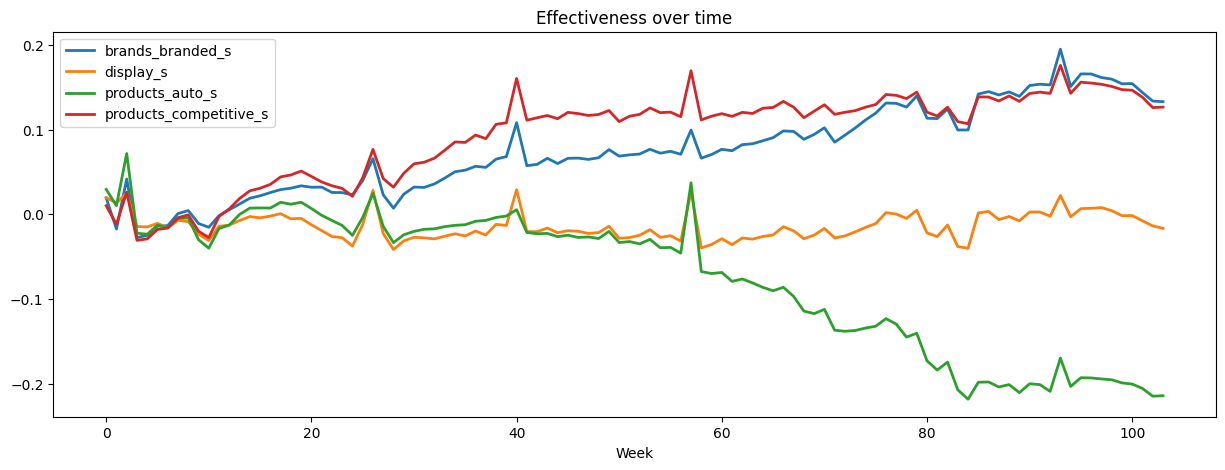

In [14]:
mmm, trace, sigma_walk, alpha, gamma, saturated_media, holiday_coefficient, seasonality, noise, intercept_coefficient, intercept, likelihood = bayesian_mmm("W")

plt.figure(figsize=(15,5))

for channel in ['brands_branded_s', 'display_s', 'products_auto_s', 'products_competitive_s']:
    plt.plot(
        trace.posterior[f'coefficient_{channel}'].values.mean(axis=(0,1)),
        linewidth=2,
        label=channel
    )

plt.title('Effectiveness over time')
plt.xlabel('Week')
plt.legend()
plt.show()

In [15]:
media_decomp = pd.DataFrame({i:np.array(trace['posterior']["contribution_"+str(i)]).mean(axis=(0,1)) for i in channel_priors.keys()}) * media['revenue'].mean()

C:\Users\norri\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (737) in plot_posterior, generating only 40 plots
  warnings.warn(


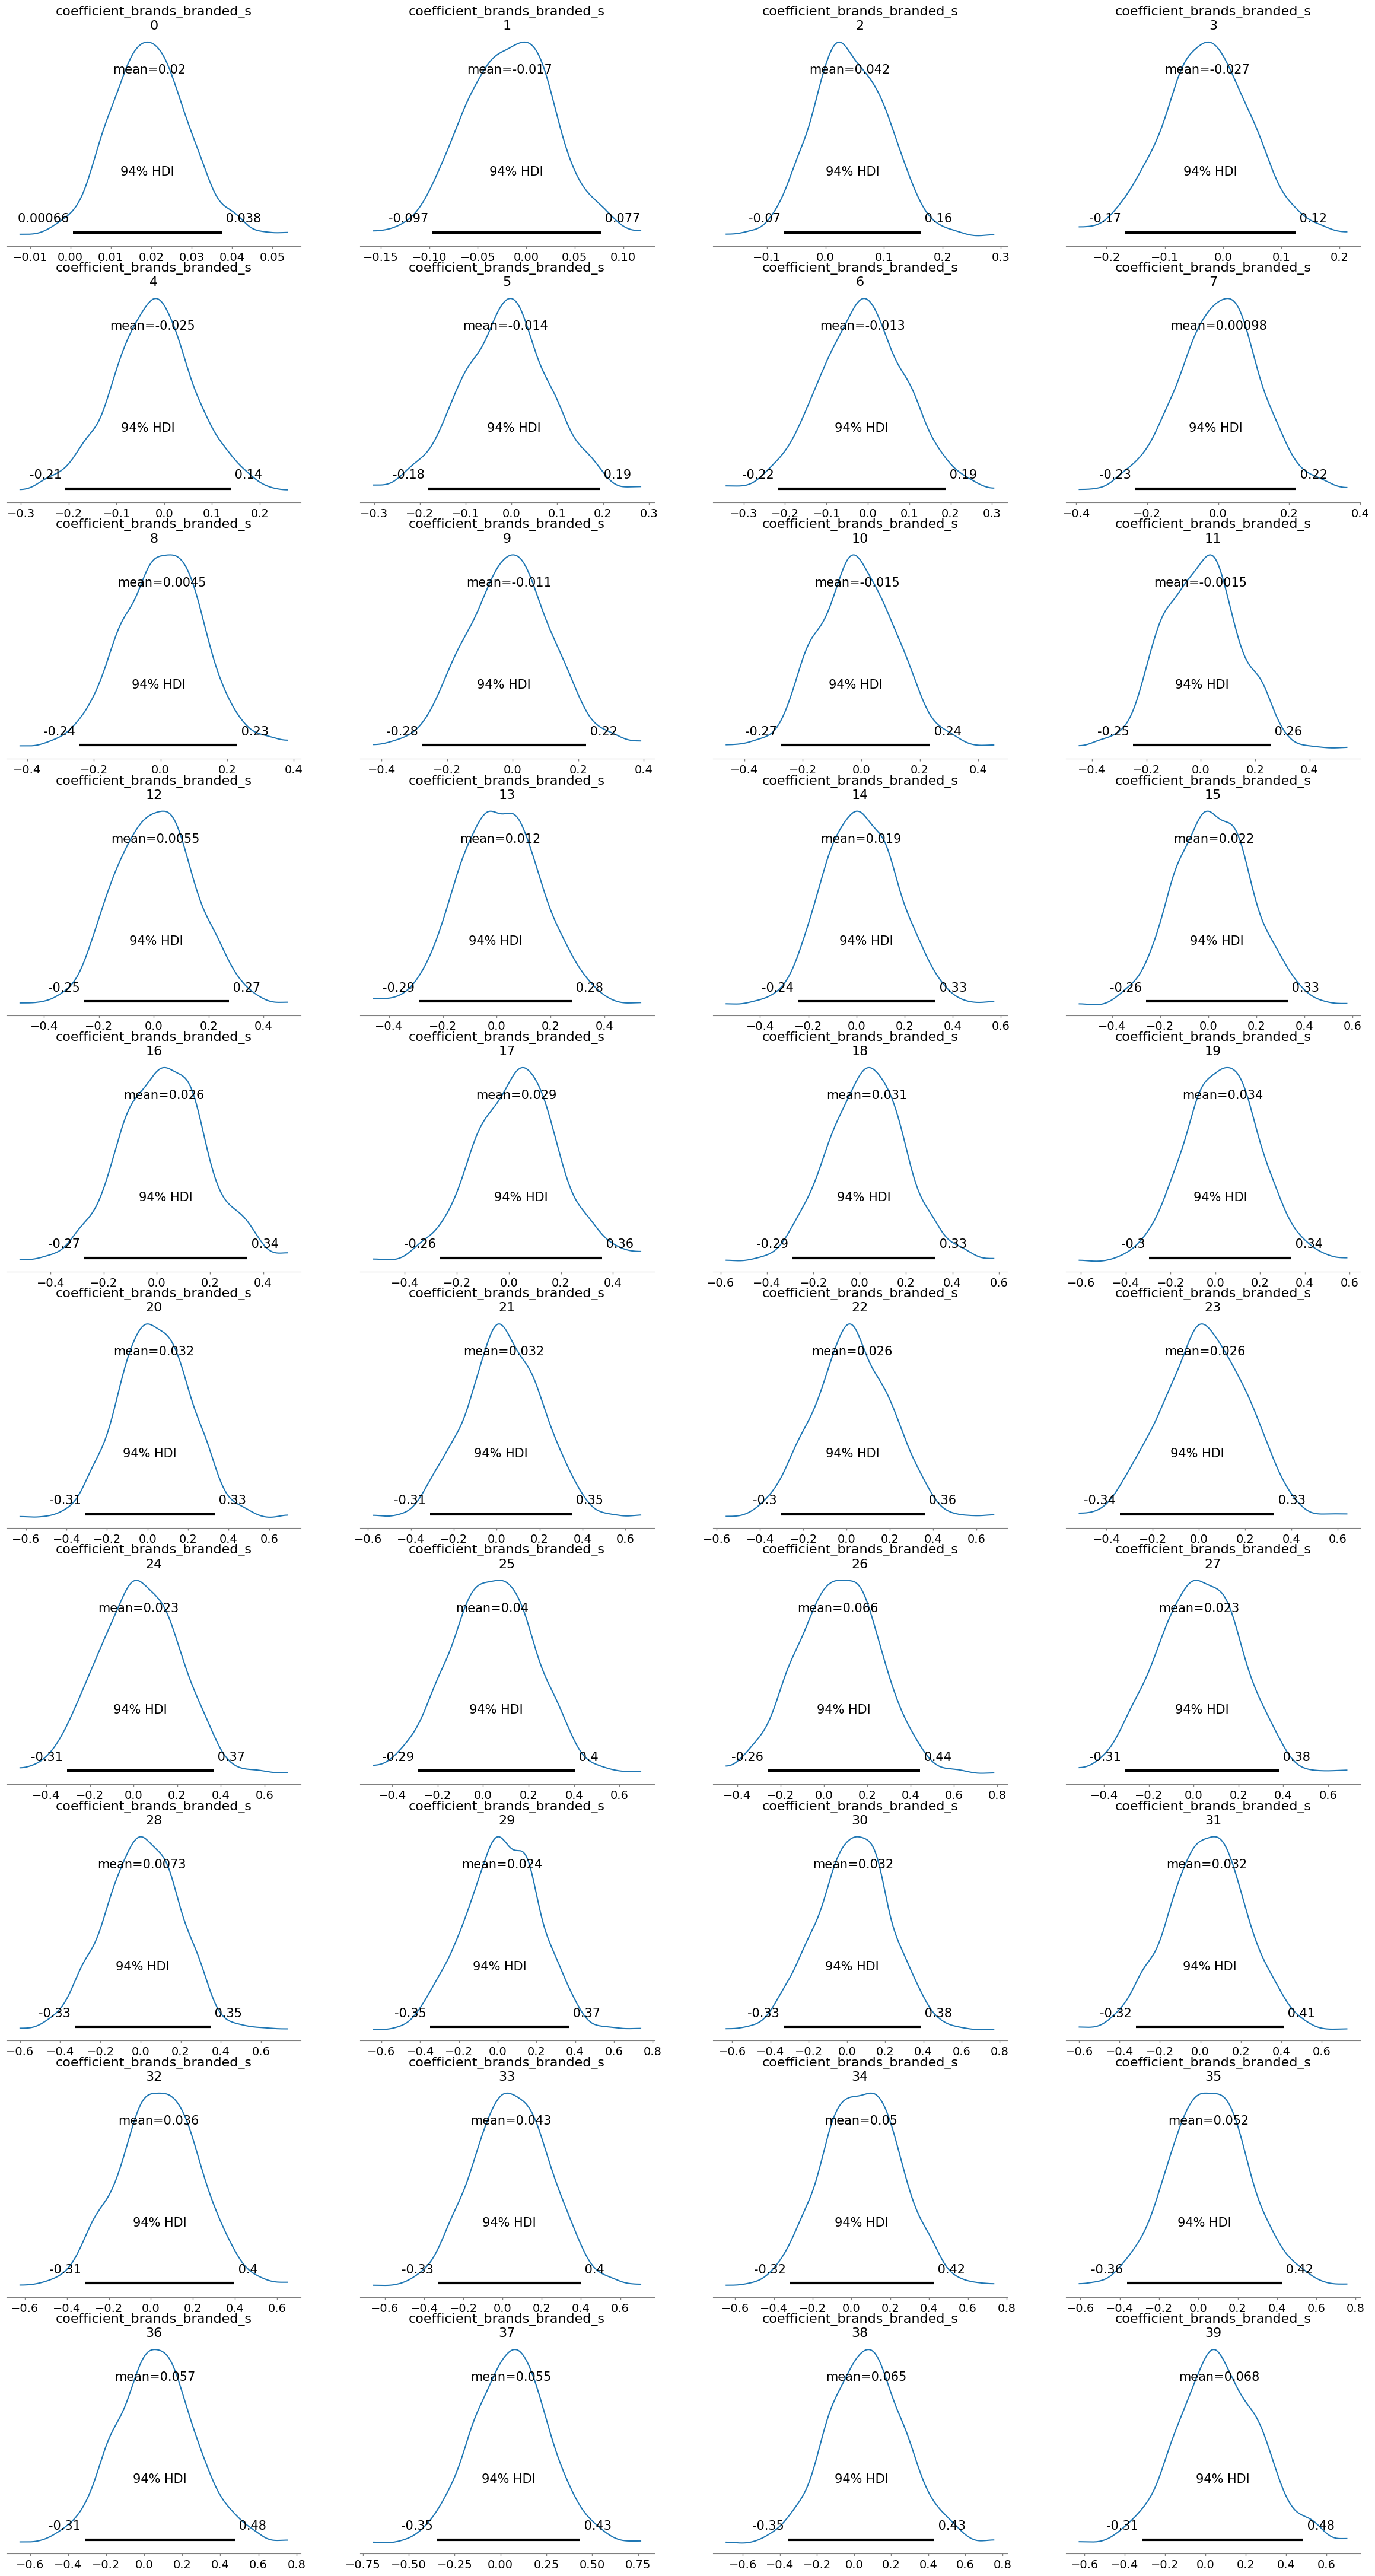

In [16]:
az.plot_posterior(
    trace,
    var_names=['intercept', 'coefficient_'],
    filter_vars='like'
);


In [17]:
posterior = pm.sample_posterior_predictive(trace, mmm)
predictions = posterior['posterior_predictive']['REVENUE'].mean(axis=0).mean(axis=0) * media['revenue'].mean()

Sampling: [REVENUE]


In [18]:
# mmm, trace = bayesian_mmm("Q")
# idx = pd.PeriodIndex(start='2020-6-10 09:00', end='2021-6-10 09:00', freq='Q')
# products_category_s_df = pd.DataFrame({
#     'quarter': "Quarter "+pd.PeriodIndex(idx, freq='Q').astype(str).str[-1].astype(str).values,
#     'coefficient': trace['posterior']['coefficient_products_category_s'].mean(axis=(0,1))
# })
# 
# products_category_s_df.groupby('quarter').mean().plot.bar();
# plt.title("Paid Search Effectiveness over Quarters")
# plt.ylim(bottom=0.12)

DateParseError: Unknown datetime string format, unable to parse: D

In [19]:
mmm, trace = bayesian_mmm("YoY")

products_category_s_df = pd.DataFrame({
    'year': np.array(["Year before that"]*52 + ["Last Year"]*52),
    'coefficient': trace['posterior']['coefficient_products_category_s'].mean(axis=(0,1))
})

display(products_category_s_df.groupby('year').mean())

products_category_s_df.groupby('year').mean().plot.bar();
plt.ylim(bottom=0.12)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_walk, coefficient_brands_branded_s, alpha_brands_branded_s, gamma_brands_branded_s, coefficient_brands_competitive_s, alpha_brands_competitive_s, gamma_brands_competitive_s, coefficient_display_s, alpha_display_s, gamma_display_s, coefficient_products_auto_s, alpha_products_auto_s, gamma_products_auto_s, coefficient_products_branded_s, alpha_products_branded_s, gamma_products_branded_s, coefficient_products_category_s, alpha_products_category_s, gamma_products_category_s, coefficient_products_competitive_s, alpha_products_competitive_s, gamma_products_competitive_s, coefficient_holiday, coefficient_trend, coefficient_seasonality_cos_1, coefficient_seasonality_sin_1, coefficient_seasonality_cos_2, coefficient_seasonality_sin_2, sigma, coefficient_intercept]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1898 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


ValueError: too many values to unpack (expected 2)

Text(0.5, 1.0, 'Model Fit')

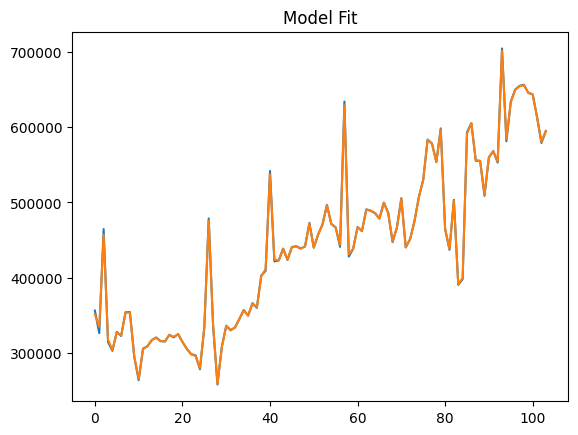

In [20]:
media.reset_index(drop=True, inplace=True)
plt.plot(media['revenue'])
plt.plot(predictions)
plt.title("Model Fit")

In [21]:
mmm, trace = bayesian_mmm("W")

import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

for channel in ['brands_branded_s', 'display_s', 'products_auto_s', 'products_competitive_s']:
    plt.plot(
        trace.posterior[f'coefficient_{channel}'].values.mean(axis=(0,1)),
        linewidth=2,
        label=channel
    )

plt.title('Effectiveness over time')
plt.xlabel('Week')
plt.legend()
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_walk, coefficient_brands_branded_s, alpha_brands_branded_s, gamma_brands_branded_s, coefficient_brands_competitive_s, alpha_brands_competitive_s, gamma_brands_competitive_s, coefficient_display_s, alpha_display_s, gamma_display_s, coefficient_products_auto_s, alpha_products_auto_s, gamma_products_auto_s, coefficient_products_branded_s, alpha_products_branded_s, gamma_products_branded_s, coefficient_products_category_s, alpha_products_category_s, gamma_products_category_s, coefficient_products_competitive_s, alpha_products_competitive_s, gamma_products_competitive_s, coefficient_holiday, coefficient_trend, coefficient_seasonality_cos_1, coefficient_seasonality_sin_1, coefficient_seasonality_cos_2, coefficient_seasonality_sin_2, sigma, coefficient_intercept]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1911 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


ValueError: too many values to unpack (expected 2)

In [ ]:
media_decomp = pd.DataFrame({i:np.array(trace['posterior']["contribution_"+str(i)]).mean(axis=(0,1)) for i in channel_priors.keys()}, index='DATE' * media['revenue'].mean())

In [ ]:
media_roi = pd.concat([
    media.drop(['DATE','revenue'],axis=1).sum(),
    media_decomp.sum()
], axis=1).reset_index()

In [ ]:

media_roi.columns = ['media','spend','revenue']

media_roi['ROI'] = (media_roi['revenue'] / media_roi['spend'])
media_roi = media_roi.merge(model, left_on='media', right_on='variable')

media_roi.drop(['variable','alpha','gamma'], axis=1, inplace=True)

media_roi

In [ ]:
def get_response_curve(channel, start_time, end_time):

    def hill_transform(x, alpha, gamma):
        return 1 / (1 + (x/gamma)**-alpha)

    # parameters
    coefficient = opt_model.query("variable == @channel")['coefficient'].iloc[0]
    alpha = opt_model.query("variable == @channel")['alpha'].iloc[0]
    gamma = opt_model.query("variable == @channel")['gamma'].iloc[0]

    # means for inverse scaling
    spend_mean = media.query("DATE >= @start_time and DATE <= @end_time")[channel].mean()
    revenue_mean = media.query("DATE >= @start_time and DATE <= @end_time")['REVENUE'].mean()

    # actual spend and contribution
    spend = media.query("DATE >= @start_time and DATE <= @end_time")[channel].sum()
    REVENUE = hill_transform(spend / spend_mean, alpha, gamma) * coefficient * revenue_mean

    spend_axis = np.arange(spend/10, spend*2, 1e03)
    revenue_axis = hill_transform(spend_axis / spend_mean, alpha, gamma) * coefficient * revenue_mean

    return spend_axis, revenue_axis, spend, REVENUE

spend_axis, revenue_axis, spend, REVENUE = get_response_curve('products_category_s', '2022-11-01', '2023-01-01')
plt.plot(spend_axis, revenue_axis)
x0, y0 = spend, REVENUE
plt.plot(x0, y0, "s");
plt.xlabel('Spend');
plt.ylabel('Revenue');
plt.title('Paid Search Response Curve');

In [ ]:
current_revenue = media_roi['REVENUE'].sum()
current_budget = media_roi['spend'].sum()
new_budget = current_budget * 1.05

In [ ]:
# initialize model
opt_model = grb.Model(name="Media Budget Optimization")

x_vars = opt_model.addVars(media_roi['media'], vtype=grb.GRB.CONTINUOUS,
                           lb=0, name="media")

# keep total spend less than new available budget
opt_model.addConstr(sum(x_vars[i] for i in media_roi['media']) <=
                    new_budget, name="New Budget")

# keep new media spend within +-25%
for i in media_roi['media']:
    # minimum
    opt_model.addConstr(
        x_vars[i] >= 0.75 * media_roi.query("media == @i")['spend'].iloc[0],
        name=f"{i}_min_spend"
    )

    # maximum
    opt_model.addConstr(
        x_vars[i] <= 1.25 * media_roi.query("media == @i")['spend'].iloc[0],
        name=f"{i}_max_spend"
    )

# objective function to maximize return on spend
opt_model.setObjective(sum(x_vars[i] * media_roi.query("media == @i")['ROI'].iloc[0]
                           for i in media_roi['media']))

# run
opt_model.ModelSense = grb.GRB.MAXIMIZE
opt_model.optimize()

In [ ]:
# Value of the objective function (ROI)
print(f"The Optimal Objective Value {opt_model.objVal}")
# Values of decision variables (Funds allocated to each channel)
opt_df = pd.DataFrame.from_dict(x_vars, orient="index", columns=["Variable Object"])
opt_df.reset_index(inplace=True)
opt_df.rename(columns={"index": "Media"}, inplace=True)
opt_df["Budget Allocated"] = opt_df["Variable Object"].apply(lambda item: item.X)

plt.bar(opt_df["Media"], opt_df["Budget Allocated"])
plt.xlabel("Media")
plt.ylabel("Budget Allocated")
plt.title("Optimized Budget Allocation")
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()